# Getting Started

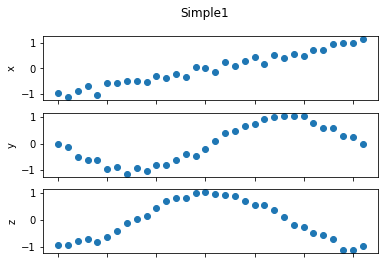

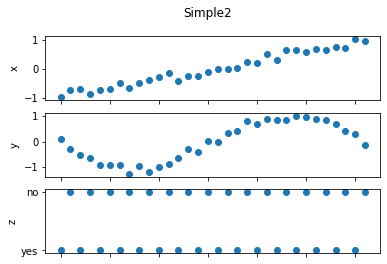

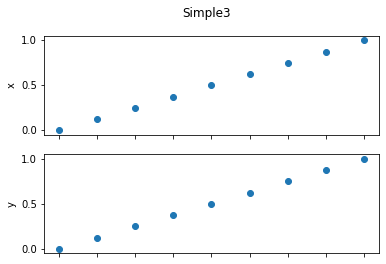

In [1]:
from deepecho.benchmark import Simple1, Simple2, Simple3

for benchmark in [Simple1(), Simple2(), Simple3()]:
    fig = benchmark.visualize()
    fig.suptitle(benchmark.__class__.__name__)

In [2]:
from deepecho.model import AlphaModel, BetaModel

for benchmark in [Simple1(), Simple2()]:
    print("Benchmark:", benchmark.__class__.__name__)
    for model in [AlphaModel(), BetaModel()]:
        results = benchmark.evaluate(model)
        print("  %s\n    %s\n" % (model.__class__.__name__, results))

Benchmark: Simple1


Epoch 12 | Log Likelihood -2.9358649253845215:   1%|          | 9/1024 [00:00<00:11, 86.83it/s]

  AlphaModel
    {'mean-squared-error': 0.010823896804973445}



Epoch 1023 | Log Likelihood 2.823897361755371: 100%|██████████| 1024/1024 [00:10<00:00, 93.49it/s]  


  BetaModel
    {'mean-squared-error': 0.009709956538736199}

Benchmark: Simple2


Epoch 13 | Log Likelihood -2.5588300228118896:   1%|          | 10/1024 [00:00<00:10, 97.00it/s]

  AlphaModel
    {'mean-squared-error': 0.1406605114718106, 'accuracy': 0.434375}



Epoch 1023 | Log Likelihood 1.8204494714736938: 100%|██████████| 1024/1024 [00:11<00:00, 87.62it/s]  


  BetaModel
    {'mean-squared-error': 0.010976561491062718, 'accuracy': 0.975}



In [3]:
from deepecho.model import GammaModel

for benchmark in [Simple3()]:
    print("Benchmark:", benchmark.__class__.__name__)
    for model in [GammaModel()]:
        results = benchmark.evaluate(model)
        print("  %s\n    %s\n" % (model.__class__.__name__, results))

Epoch 12 | Log Likelihood -32.144474029541016:   1%|          | 9/1024 [00:00<00:12, 78.36it/s]

Benchmark: Simple3


Epoch 1023 | Log Likelihood 92.30638122558594: 100%|██████████| 1024/1024 [00:12<00:00, 80.41it/s] 


  GammaModel
    {'mean-squared-error': 0.44297352969423887, '|E[L]-\\hat{L}|': 3.5999999999999996}

